# Creating a heatmap of the units added against Community Area

## Step 1: Preprocess the Data

In [11]:
import pandas as pd
import numpy as np

# Read the Excel file
df = pd.read_excel('Copy of New Raw Data.xlsx')

# Drop rows with all NaN values (empty rows)
df.dropna(how='all', inplace=True)

# Create an empty DataFrame to store the cleaned data
cleaned_df = pd.DataFrame(columns=["Units Added", "Ward Number", "Community Number", "Community Name"])

# Initialize variables to store data
units_added = None
ward_number = None
community_number = None
community_name = None

# Iterate through the rows of the DataFrame
for index, row in df.iterrows():
    if not pd.isna(row["Units"]):
        # Extract units added
        units_added = row["Units"]

    if "Ward:" in str(row["Ward & Community Area"]):
        # Extract ward number from "Ward:" lines
        ward_number = str(row["Ward & Community Area"]).split(":")[1].strip()
    elif not pd.isna(row["Ward & Community Area"]) and "-" in str(row["Ward & Community Area"]):
        # Extract community information from community lines
        community_info = str(row["Ward & Community Area"]).split("-")
        if len(community_info) == 2:
            # Extract community number and name
            community_number = community_info[0].strip()
            community_name = community_info[1].strip()
            
            # Remove leading zeros from community numbers and convert to integers
            if community_number.isdigit():
                community_number = str(int(community_number))

            # Append data to the cleaned DataFrame
            cleaned_df = cleaned_df.append({
                "Units Added": units_added,
                "Ward Number": ward_number,
                "Community Number": community_number,
                "Community Name": community_name
            }, ignore_index=True)

# Display the cleaned DataFrame
print(cleaned_df)

# Use describe() to get summary statistics
summary_stats = cleaned_df["Units Added"].describe()

# Display the summary 
display(summary_stats)

# Calculate the total number of units added
total_units_added = cleaned_df["Units Added"].sum()

# Display the total number of units added
print(f"Total Units Added: {total_units_added}")


     Units Added Ward Number Community Number  Community Name
0            2.0          27               28  Near West Side
1           10.0          27               28  Near West Side
2            1.0          20               61        New City
3            1.0          10               46   South Chicago
4            1.0          16               66    Chicago Lawn
..           ...         ...              ...             ...
137          1.0          35               22    Logan Square
138          2.0           5               42        Woodlawn
139          1.0          29               25          Austin
140          1.0          27               23   Humbodlt Park
141          9.0           5               43     South Shore

[142 rows x 4 columns]


/var/folders/06/4lfc08752zv_l79gm6nmv18w0000gn/T/ipykernel_78954/3004491564.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cleaned_df = cleaned_df.append({
/var/folders/06/4lfc08752zv_l79gm6nmv18w0000gn/T/ipykernel_78954/3004491564.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cleaned_df = cleaned_df.append({
/var/folders/06/4lfc08752zv_l79gm6nmv18w0000gn/T/ipykernel_78954/3004491564.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cleaned_df = cleaned_df.append({
/var/folders/06/4lfc08752zv_l79gm6nmv18w0000gn/T/ipykernel_78954/3004491564.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cleaned_df = cleaned_df.appen

count    142.000000
mean       1.373239
std        1.176659
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       10.000000
Name: Units Added, dtype: float64

Total Units Added: 195.0


In [12]:
# Save the summary statistics to an Excel file
cleaned_df.to_excel('cleaned_df.xlsx')


## 2. Heatmap

I'll need geographical data for Chicago's Community Areas. I can find a GeoJSON file representing Chicago Community Areas online.

You can obtain GeoJSON data for Chicago's Community Areas from various sources. One of the reliable sources is the City of Chicago's Data Portal, which provides datasets in various formats, including GeoJSON. Here's how you can get Chicago's Community Areas GeoJSON data from the City of Chicago's Data Portal:

Visit the City of Chicago's Data Portal at https://data.cityofchicago.org/.

https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6

On the dataset's page, you should see an option to export the data. Look for the "Export" button or link.

From the export options, select "GeoJSON" as the export format.

Click the "Download" button to download the GeoJSON file to your computer.

Save the GeoJSON file to a location on your computer, and remember the file path.

In [92]:
# pip install geopandas


Total Aggregated Units: 195


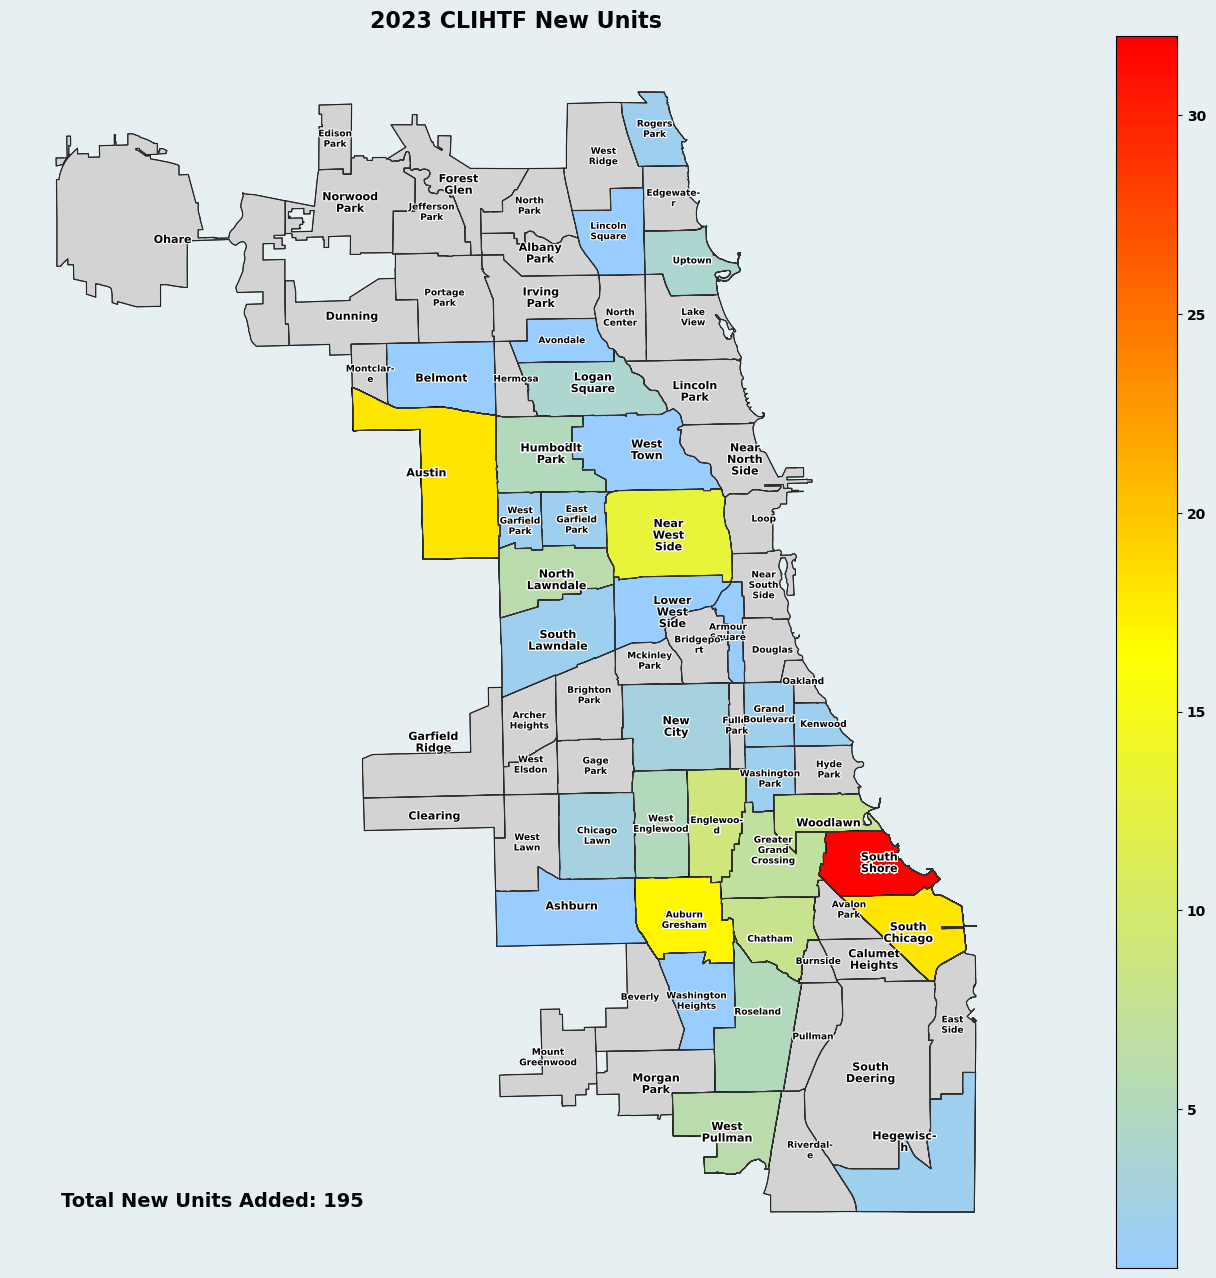

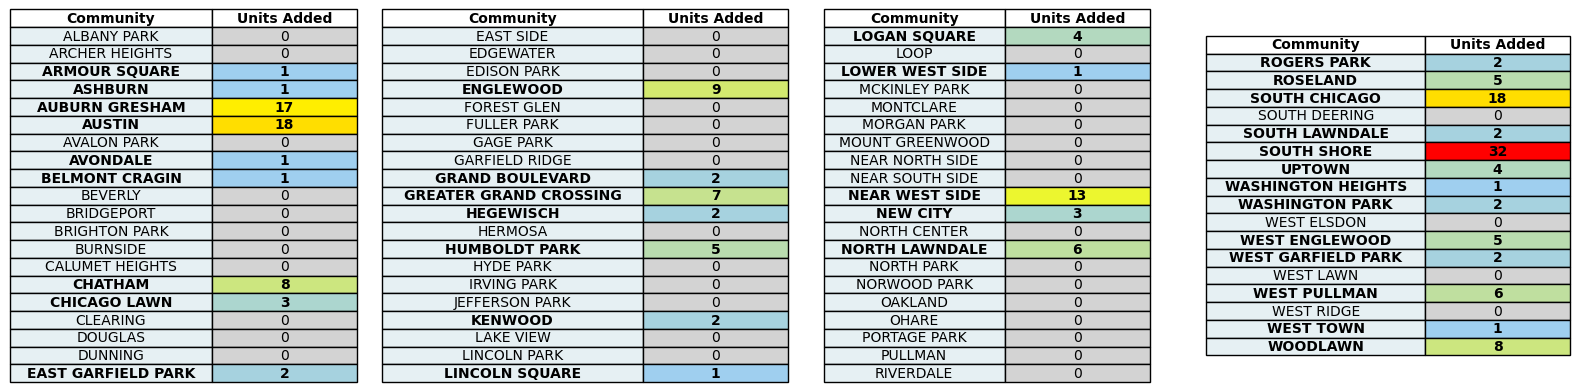

In [13]:
# Import the necessary libraries
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patheffects import withStroke
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib as mpl  # Import matplotlib

# Adjust the font weight globally
mpl.rcParams['font.weight'] = 'bold'  # Set font weight to bold

# Load the GeoJSON data
geojson_file_path = 'Boundaries - Community Areas.geojson'
geo_df = gpd.read_file(geojson_file_path)

# Merge the GeoJSON data with your cleaned_df based on 'Community Number'
merged_df = geo_df.merge(cleaned_df, left_on='area_numbe', right_on='Community Number', how='left')

# Create a GeoDataFrame from the merged DataFrame
gdf = gpd.GeoDataFrame(merged_df)

# Define a custom colormap with blue, yellow, and red
colors = [(0, '#99ccff'), (0.5, 'yellow'), (1, 'red')]  # Use a lighter blue color code
cmap = LinearSegmentedColormap.from_list('custom_colormap', colors)

# Reproject geometries to a projected CRS
gdf = gdf.to_crs(epsg=3395)  # You can choose an appropriate projected CRS

# Convert 'Units Added' to numeric with NaN for non-numeric values
gdf['Units Added'] = pd.to_numeric(gdf['Units Added'], errors='coerce')

# Group by community and calculate the sum of 'Units Added'
aggregated_units = gdf.groupby('community')['Units Added'].sum().reset_index()

# Merge the aggregated units back into the GeoDataFrame
gdf = gdf.merge(aggregated_units, on='community', suffixes=('', '_agg'), how='left')

# Separate communities with non-numeric or blank 'Units Added'
communities_with_invalid_units = gdf[gdf['Units Added'].isna()]

# Calculate the horizontal widths of the middle of the vertical length
horizontal_widths = []
for idx, row in gdf.iterrows():
    min_x, min_y, max_x, max_y = row['geometry'].bounds
    middle_x = (min_x + max_x) / 2
    horizontal_width = max_x - min_x
    horizontal_widths.append(horizontal_width)

# Calculate the 50% percentile of horizontal widths
percentile_50 = pd.Series(horizontal_widths).quantile(0.5)

# Calculate and format the total aggregated units as text
total_units_text = f"Total New Units Added: {int(total_units_added)}"

# Plot communities with non-zero units added
fig, ax = plt.subplots(1, 1, figsize=(24, 16))

# Set the background color for the entire figure to light blue-grey
fig.set_facecolor('#E6F0F3')

# Plot area outlines with thinner dark grey border
gdf.boundary.plot(ax=ax, color='#333333', linewidth=0.5)

# Plot communities with non-zero units added using a colormap
gdf_with_units = gdf[gdf['Units Added'].notna()]
gdf_no_units = gdf[gdf['Units Added'].isna()]

# Color communities with no units added as light gray
no_units_color = 'lightgray'
gdf_no_units.plot(color=no_units_color, ax=ax, linewidth=0.8, edgecolor='k', legend=True)
gdf_with_units.plot(column='Units Added_agg', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='k', legend=True)

ax.set_title('2023 CLIHTF New Units', fontsize=16, fontweight='bold')  # Adjust fontsize as needed
plt.axis('off')  # Turn off axis

# Annotate the map with community names
labels = []

for idx, row in gdf.iterrows():
    label = row['Community Name'] if pd.notna(row['Community Name']) else row['community']
    units = row['Units Added_agg']
    shape_len = row['shape_len']

    # Calculate the midpoint of the horizontal length
    min_x, min_y, max_x, max_y = row['geometry'].bounds
    middle_x = (min_x + max_x) / 2
    middle_y = (min_y + max_y) / 2

    # Convert label to title case
    label = label.title()

    fontsize = 8 if pd.notna(units) else 6  # Default fontsize
    label_length = len(label)

    # Check if label contains a space and split into lines accordingly
    lines = label.split()
    if len(lines) > 1:
        # Create a second line for text containing a space
        label = '\n'.join(lines)

    # Check if the length of the longer line of text is greater than 7
    if label_length > 8 and '\n' not in label:
        # Add a hyphen and create a new line
        label = label[:8] + '-\n' + label[8:]

    # Check if horizontal width is in the bottom 50% percentile and reduce fontsize by 2 if true
    if pd.notna(shape_len) and max_x - min_x <= percentile_50:
        fontsize -= 1.5

    labels.append((middle_x, middle_y, label, fontsize))

# Remove old labels
for label in ax.texts:
    label.remove()

# Annotate the map with community names without overlaps, recentered horizontally and vertically
for middle_x, middle_y, label, fontsize in labels:
    ax.text(middle_x, middle_y, label, fontsize=fontsize, ha='center', va='center',
            path_effects=[withStroke(linewidth=1.5, foreground='white')])  # Adjust the linewidth here

# Display the total number of aggregated units as a text label on the map
ax.text(0.05, 0.05, total_units_text, transform=ax.transAxes, fontsize=14, fontweight='bold', color='black')

# Sort the GeoDataFrame by community name
gdf = gdf.sort_values(by='community')

# Drop duplicates and keep the first occurrence
gdf = gdf.drop_duplicates(subset='community', keep='first')

# Split data into four sections for tables
num_sections = 4

# Calculate the number of communities in each section
num_communities = len(gdf)
communities_per_section = (num_communities + num_sections - 1) // num_sections

# Create a list to hold tables
tables = []

# Create figure and axes for tables
fig_tables, axs = plt.subplots(1, num_sections, figsize=(16, 4))  # Adjust the width as needed

# Plot tables
for i in range(num_sections):
    start_idx = i * communities_per_section
    end_idx = min((i + 1) * communities_per_section, num_communities)
    table_data_units = gdf[['community', 'Units Added_agg']].iloc[start_idx:end_idx]
    table_data_units['Units Added_agg'] = table_data_units['Units Added_agg'].astype(int) # Convert to integer format
    columns_units = ['Community', 'Units Added']

    # Calculate the maximum width needed for each cell in the "Community" column
    max_width_community = table_data_units['community'].apply(lambda x: len(str(x))).max() * 0.6

    # Create a new DataFrame for coloring cells
    table_data_color = pd.DataFrame(index=table_data_units.index, columns=table_data_units.columns)

    for col in table_data_color.columns:
        if col in ['Community']:
            continue
        values = table_data_units[col]

        # Check if the column contains numeric data
        if pd.api.types.is_numeric_dtype(values):
            norm = plt.Normalize(gdf['Units Added_agg'].min(), gdf['Units Added_agg'].max())  # Use the entire range
            colors = cmap(norm(values))

            # Handle NaN and 0 values separately
            cell_colors = [no_units_color if (pd.isna(values.iloc[i]) or values.iloc[i] == 0) else colors[i] for i in range(len(values))]
            table_data_color[col] = cell_colors
        else:
            # Handle non-numeric columns (e.g., 'Community')
            table_data_color[col] = ['#E6F0F3' if pd.notna(c) else None for c in values]

    table = axs[i].table(cellText=table_data_units.values, colLabels=columns_units, cellLoc='center', loc='center')
    table.auto_set_font_size(False)

    # Set the maximum cell width for the "Community" column
    table.auto_set_column_width([0])  # Adjust the column index if needed

    # Apply cell background colors
    for row_idx in range(len(table_data_color)):
        for col_idx, color in enumerate(table_data_color.iloc[row_idx]):
            cell = table.get_celld()[row_idx+1, col_idx]
            cell.get_text().set_fontweight('normal')  # Set font weight to normal for all columns
            if color is not None:
                cell.set_facecolor(color)  # Set background color

    # Bold text and Community where 'Units Added' is greater than 0
    for row_idx, units_added in enumerate(table_data_units['Units Added_agg']):
        if units_added > 0:
            cell_text = table.get_celld()[row_idx+1, 1].get_text()  # Get the 'Units Added' cell text
            cell_text.set_fontweight('bold')  # Bold the text in the 'Units Added' cell
            cell_community = table.get_celld()[row_idx+1, 0].get_text()  # Get the 'Community' cell text
            cell_community.set_fontweight('bold')  # Bold the text in the 'Community' cell

    # Set the table width
    table.scale(1, 1)

    # Remove axis from the tables
    axs[i].axis('off')

    tables.append(table)

plt.tight_layout()  # Adjust layout for better label display

# Save the figure as a PDF
# Increase the DPI when saving the figure as a PDF
# Save the figure as a PDF with vector graphics format (e.g., SVG)
pdf_pages = PdfPages('community_map_and_tables.pdf')
pdf_pages.savefig(fig, bbox_inches='tight')  # Use vector graphics format
pdf_pages.savefig(fig_tables, bbox_inches='tight')  # Use vector graphics format
pdf_pages.close()

total_units_aggregated = gdf['Units Added_agg'].sum()
print(f"Total Aggregated Units: {int(total_units_aggregated)}")  # Format as integer

plt.show()  # Display the final plot
